In [1]:
import numpy as np
%matplotlib inline

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


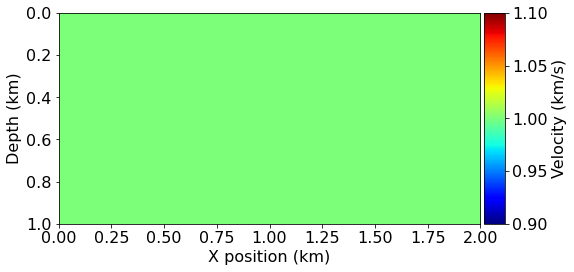

(2000.0, 1000.0)


In [2]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import *

# Define a physical size
shape = (201, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:,:] = 1

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

plot_velocity(model)
print(model.domain_size)

In [3]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print(dt)

6.124


(165, 1)


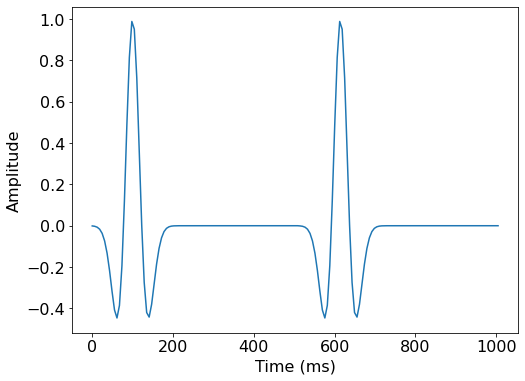

In [4]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# Set source coordinates
src.coordinates.data[0, 0] =model.domain_size[0] * .5
src.coordinates.data[0, 1] =0#model.domain_size[1] * .5
print(src.data.shape)
src.data[84:,0]=src.data[:81,0]
#src.data[:62,0]+=src.data[62:,0]
# We can plot the time signature to see the wavelet via:
src.show()

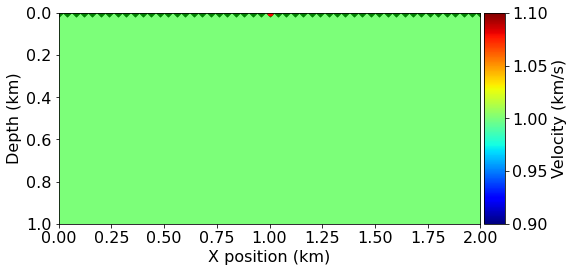

In [5]:
#NBVAL_IGNORE_OUTPUT

from examples.seismic import Receiver
from numpy import *
# Create symbol for 101 receivers
n_rec=201
rec = Receiver(name='rec', grid=model.grid, npoint=n_rec, time_range=time_range)
rec.coordinates.data[:,0]=np.linspace(0,model.domain_size[0],201)
#m0=model.domain_size[0]/2
#m1=model.domain_size[1]/2
#a,b=0.4*m0,0.6*m1
x=0
#while (x<201):
  #  rec.coordinates.data[x,0]=a*cos(x*2*pi/200+pi/3)+m0
   # rec.coordinates.data[x,1]=b*sin(x*2*pi/200+pi/3)+m1
   # x+=1
    
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4])

In [6]:
# In order to represent the wavefield u and the square slowness we need symbolic objects 
# corresponding to time-space-varying field (u, TimeFunction) and 
# space-varying field (m, Function)
from devito import TimeFunction

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# The PDE representation is as on paper
pde


damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [7]:
# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions
from devito import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward))

In [8]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)


In [9]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)


Now we can execute the create operator for a number of timesteps. We specify the number of timesteps to compute with the keyword `time` and the timestep size with `dt`.

In [10]:
#NBVAL_IGNORE_OUTPUT
op(time=time_range.num-1, dt=model.critical_dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.005330999999999984, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=1.9000000000000004e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0008960000000000001, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

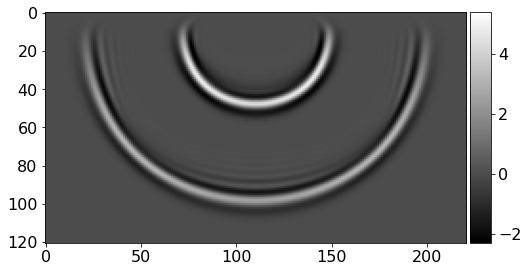

In [11]:
plot_image(u.data[0])

After running our operator kernel, the data associated with the receiver symbol `rec.data` has now been populated due to the interpolation expression we inserted into the operator. This allows us the visualize the shot record:

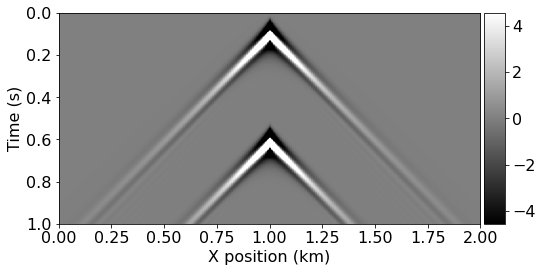

In [12]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)

In [13]:
rec.data.shape
import numpy
numpy.set_printoptions(threshold=math.inf)
#temp=list(rec.data[115])
#m=max(temp)
#temp.index(m)
print(rec.data[:,100])

[ 0.00000000e+00 -1.02658540e-01 -3.17828983e-01 -7.48440862e-01
 -1.64733207e+00 -3.33554864e+00 -6.13630486e+00 -1.02167301e+01
 -1.52682161e+01 -2.02179337e+01 -2.31723385e+01 -2.18105831e+01
 -1.43617001e+01 -8.09063435e-01  1.64156837e+01  3.28504295e+01
  4.36116943e+01  4.54996567e+01  3.84025421e+01  2.51937141e+01
  1.02647915e+01 -2.40973997e+00 -1.06197395e+01 -1.41475658e+01
 -1.41282530e+01 -1.21462975e+01 -9.54364204e+00 -7.13408470e+00
 -5.24516392e+00 -3.89088058e+00 -2.95087147e+00 -2.29473805e+00
 -1.82328355e+00 -1.46693349e+00 -1.18350899e+00 -9.51090336e-01
 -7.59263992e-01 -6.04384422e-01 -4.80807602e-01 -3.79216045e-01
 -2.95618594e-01 -2.30593145e-01 -1.81924671e-01 -1.44902930e-01
 -1.14531219e-01 -8.79421979e-02 -6.67316988e-02 -5.17895259e-02
 -3.95610556e-02 -2.74532177e-02 -1.63635761e-02 -7.97639973e-03
 -3.44379013e-03 -1.80061394e-03 -8.46171984e-04 -1.03774993e-03
 -3.86145920e-03 -8.24139826e-03 -1.23031493e-02 -1.50777493e-02
 -1.64003167e-02 -1.72931

In [15]:
n_events=2
t_rec=np.zeros(shape=(n_rec,n_events))
for i in range(0,n_rec):
    # n_events is not known
    x=0
    for j in range(0,rec.data.shape[0]-2):
        if( (abs(rec.data[j,i])<=0.01)and (abs(rec.data[j+1,i])>=0.01 )and (abs(rec.data[j+2,i])>=0.01)):
        
        
       # if (abs(rec.data[j,i]-(rec.data[j+1,i]))<e**10*(abs(rec.data[j+1,i]-rec.data[j+2,i]))):
            t_rec[i][x]=(j+1)*dt
            x+=1 
            if x>=2:break
                

In [16]:
print(t_rec)

[[  0.           0.        ]
 [998.21201181   0.        ]
 [985.96401167   0.        ]
 [979.8400116    0.        ]
 [967.59201145   0.        ]
 [955.34401131   0.        ]
 [949.22001123   0.        ]
 [936.97201109   0.        ]
 [924.72401094   0.        ]
 [918.60001087   0.        ]
 [906.35201073 985.96401167]
 [894.10401058   0.        ]
 [887.98001051 967.59201145]
 [875.73201036   0.        ]
 [863.48401022   0.        ]
 [857.36001015 936.97201109]
 [845.11201      0.        ]
 [832.86400986   0.        ]
 [826.74000978 906.35201073]
 [814.49200964   0.        ]
 [802.24400949   0.        ]
 [796.12000942 973.71601152]
 [783.87200928   0.        ]
 [777.7480092    0.        ]
 [765.50000906 943.09601116]
 [753.25200891 961.46801138]
 [747.12800884 826.74000978]
 [734.8800087  912.4760108 ]
 [722.63200855 930.84801102]
 [716.50800848 796.12000942]
 [704.26000834 881.85601044]
 [692.01200819 900.22801065]
 [685.88800812 936.97201109]
 [673.64000797 851.23601007]
 [661.39200783

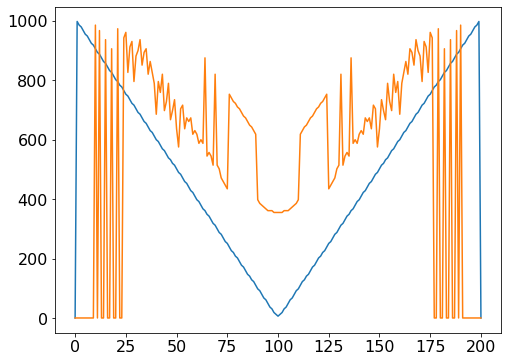

In [17]:
import  matplotlib.pyplot as plt
time_axis=np.linspace(start=0,stop=tn,num=int(tn/dt))
plt.plot(t_rec[:,0], )
plt.plot(t_rec[:,1],)